# <H1>Exploring the Austin Texas Area<H1>

<H2>importing the necessary Libraries

In [ ]:
#Importing the libraries needed to get started. 
import sys
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install folium
!pip install lxml
!pip install uszipcode
!pip install beautifulsoup4


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files


import pandas as pd
import numpy as np
import requests
import json
from bs4 import BeautifulSoup
import re
from geopy.geocoders import Nominatim
import pprint
import folium
from folium.features import DivIcon
from folium import IFrame
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.cluster import KMeans
from uszipcode import SearchEngine
from uszipcode import Zipcode
from pandas.io.json import json_normalize
import pandas as pd 
import numpy as np
import requests
print('Libraries imported.')


<H2>Credentials for Foursquare Zillow and Opencage Geocoding

In [2]:
# Four Square credentials
client_id = 'P0MEEIQBEYLE2ZANW1HBPQCG150PIQA4OQUBPWBTQIUDDMXT'
client_secret = 'RGWBZJNJD2C12JE45VGZTRARXGUBKQS41YPBGI4U2NNLLEUE'
version = '20180605'

# Zillow ZWSID
zwsid = "X1-ZWz174hlm3pybv_2ox88"

# OpenCage Geocoding API key
my_api_key = "ffa7f2d7f52241e89950f04f26c095d2"

<H2><H2> Looking at the Austin area for most populated cities to explore.

In [12]:
# Using wikipedia to get the city information. 
austin_nearby = "https://en.wikipedia.org/wiki/Greater_Austin"
response = requests.get(austin_nearby)

# BeautifulSoup to Parse
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all("table", class_="wikitable")
population_table = table[1]
pop_def = population_table.find_all('td')

city_list = []
population_list = []

#looking for the top 5:
for i in range(0, 16, 3):
    city_list.append(pop_def[i].text.strip())
    population_list.append(pop_def[i+1].contents[0])

city_df = pd.DataFrame(columns=["CityName", "Population"])
city_df["CityName"] = city_list 
city_df["Population"] = population_list
city_df

,CityName,Population
0,Austin,"978,908"
1,Round Rock,"133,372"
2,Georgetown,"79,604"
3,Cedar Park,"79,462"
4,Pflugerville,"65,380"
5,San Marcos,"64,776"


<H3> Top 3 cities with latitude and longitude using opencage

In [13]:
# Top 3 with latitude and Longitude.
city_list = ['Austin', 'Round Rock', 'Georgetown']
latitude_list = []
longitude_list = []
top_city_df = pd.DataFrame(columns=["CityName", "Population", "Latitude", "Longitude"])

for city in city_list:
    query = city + ", TX, United States of America"
    uri = "https://api.opencagedata.com/geocode/v1/json?q={}&key={}".format(query, my_api_key)
    response = requests.get(uri).json()
    latitude_list.append(response['results'][0]['geometry']['lat'])
    longitude_list.append(response['results'][0]['geometry']['lng'])
    
top_city_df["CityName"] = city_list
top_city_df["Latitude"] = latitude_list
top_city_df["Population"] = city_df["Population"]
top_city_df["Longitude"] = longitude_list
    
top_city_df


,CityName,Population,Latitude,Longitude
0,Austin,"978,908",30.271129,-97.743700
1,Round Rock,"133,372",30.508235,-97.678893
2,Georgetown,"79,604",30.671598,-97.655007


<H3> Median home value for all three cities covering 2019, 2020 and forecast for 2021.

In [14]:
# Using payload for the analysis.
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

median_values = []
last_change = []
forecast = []

cities = ["Austin", "Round-rock", "Georgetown"]
for city in cities:
    url = "https://www.zillow.com/{}-tx/home-values/".format(city)
    response = requests.get(url, headers=req_headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    median = soup.find_all('h2')
    median_values.append(median[0].text)
    
    change_list = soup.find_all('ul', class_='zsg-g')
    list_item = change_list[0].find_all('li')
    last_change.append(list_item[0].text)    
    forecast.append(list_item[1].text.strip())
    
home_value_dataframe = pd.DataFrame(columns=["City", "Last Year Value", "Current Median Value", "Next Year Forecast"])
home_value_dataframe["City"] = cities
home_value_dataframe["Last Year Value"] = last_change
home_value_dataframe["Current Median Value"] = median_values
home_value_dataframe["Next Year Forecast"] = forecast

home_value_dataframe

,City,Last Year Value,Current Median Value,Next Year Forecast
0,Austin,5.4% 1-year change,"$401,999",-0.7% 1-year forecast
1,Round-rock,-1.0% 1-year change,"$302,184",-3.4% 1-year forecast
2,Georgetown,-0.6% 1-year change,"$323,157",-3.1% 1-year forecast


In [10]:
# Need to create two lists to parse.

new_ly_values = []
new_fc_values = []

# regex pattern to clean up the data
percentage_regex = re.compile(r'\d+.\d+%')

# parsing through to match regex and adding it to the lists mentioned above.
for values in home_value_dataframe['Last Year Value']:
    sliced_value = percentage_regex.search(values)
    new_ly_values.append(sliced_value.group())

for values in home_value_dataframe['Next Year Forecast']:
    sliced_value = percentage_regex.search(values)
    new_fc_values.append(sliced_value.group())

home_value_dataframe["Last Year Value"] = new_ly_values
home_value_dataframe["Next Year Forecast"] = new_fc_values
home_value_dataframe['Current Median Value'] = home_value_dataframe['Current Median Value'].str.replace("$", "")
home_value_dataframe['Current Median Value'] = home_value_dataframe['Current Median Value'].str.replace(",", "")


home_value_dataframe

,City,Last Year Value,Current Median Value,Next Year Forecast
0,Austin,5.4%,401999,0.7%
1,Round-rock,1.0%,302184,3.4%
2,Georgetown,0.6%,323157,3.1%


In [11]:
home_value_dataframe['Last Year Value'] = home_value_dataframe['Last Year Value'].str.replace("%","")
home_value_dataframe['Next Year Forecast'] = home_value_dataframe['Next Year Forecast'].str.replace("%","")

for i in range(len(home_value_dataframe)):
    last_percent = float(home_value_dataframe.loc[i, 'Last Year Value'])
    forecast = float(home_value_dataframe.loc[i, 'Next Year Forecast'])
    median_value = float(home_value_dataframe.loc[i, 'Current Median Value'])
    
    last = float(last_percent/100)
    fore = float(forecast/100)
    home_value_dataframe.loc[i, 'Last Year Value'] = (1 - last) * median_value
    home_value_dataframe.loc[i, 'Next Year Forecast'] = (1 + fore) * median_value


home_value_dataframe

,City,Last Year Value,Current Median Value,Next Year Forecast
0,Austin,380291,401999,404813
1,Round-rock,299162,302184,312458
2,Georgetown,321218,323157,333175


<H3>Providing one consoidated view of the findings using the methodology and data.

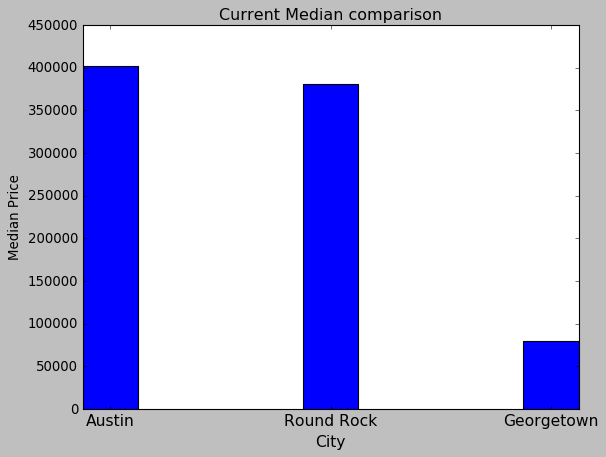

In [12]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
from pandas import Series, DataFrame
 
# plotting the health venues in three cities for easier comparison
data = [401999, 380291, 79604]
labels = ["Austin","Round Rock", "Georgetown"]
width = .25
plt.xticks(range(len(data)), labels, fontsize=14)
plt.xlabel('City',fontsize=14)
plt.ylabel('Median Price')
plt.title("Current Median comparison")
plt.xticks(range(len(data)), labels)
plt.bar(range(len(data)), data, width=width, color= 'blue') 

plt.show() 


<H3> Providing three individual views for a comparison within each city.

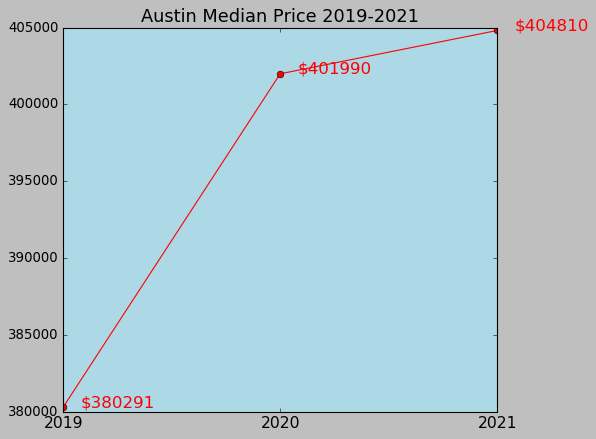

In [13]:
# Austin Median Compare
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
from pandas import Series, DataFrame
  

plt.rcParams['axes.facecolor']='lightblue'
plt.rcParams['savefig.facecolor']='lightblue'


x = [2019, 2020, 2021]
y = [380291,401990,404810]

my_xticks = ['2019', '2020', '2021']
plt.figure(figsize=(7,6))

plt.xticks(x, my_xticks, fontsize=14)
plt.yticks(fontsize=12)

plt.title("Austin Median Price 2019-2021", fontsize=16, color = 'black')
plt.plot(x , y, 'b-o',color ='red')
for a, b in zip(x, y):
    val = "$" + str(b)
    plt.text(a+0.08, b, val, fontsize=15, color='red' )
        

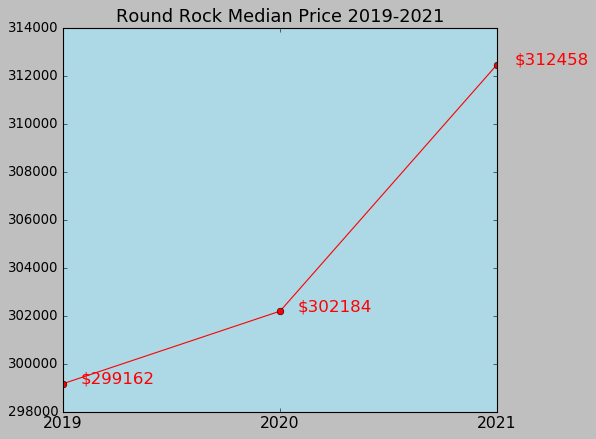

In [14]:
# Round rock median compare
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
from pandas import Series, DataFrame
  

plt.rcParams['axes.facecolor']='lightblue'
plt.rcParams['savefig.facecolor']='lightblue'


x = [2019, 2020, 2021]
y = [299162, 302184,312458]

my_xticks = ['2019', '2020', '2021']
plt.figure(figsize=(7,6))

plt.xticks(x, my_xticks, fontsize=14)
plt.yticks(fontsize=12)

plt.title("Round Rock Median Price 2019-2021", fontsize=16, color = 'black')
plt.plot(x , y, 'b-o',color ='red')
for a, b in zip(x, y):
    val = "$" + str(b)
    plt.text(a+0.08, b, val, fontsize=15, color='red' )

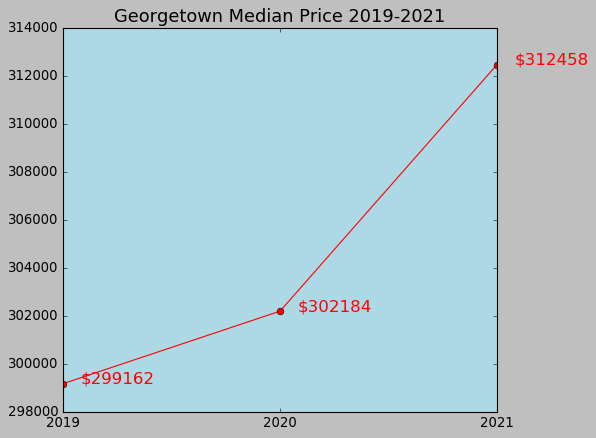

In [15]:
# Georgetown median compare
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
from pandas import Series, DataFrame
  
x = [2019, 2020, 2021]
y = [299162, 302184,312458]
plt.rcParams['axes.facecolor']='lightblue'
plt.rcParams['savefig.facecolor']='lightblue'

my_xticks = ['2019', '2020', '2021']
plt.figure(figsize=(7,6))

plt.xticks(x, my_xticks, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Georgetown Median Price 2019-2021", fontsize=16, color = 'black')
plt.plot(x , y, 'b-o',color ='red')
for a, b in zip(x, y):
    val = "$" + str(b)
    plt.text(a+0.08, b, val, fontsize=15, color='red' )

<H2> Exploring the housing prices based on median values

<H3>Looking for the median household income leveraging zipmaps 

In [16]:
# Getting zip codes of austin for the search

austin_zip = "http://www.city-data.com/zipmaps/Austin-Texas.html"
response = requests.get(austin_zip)
ziplist = []
# Parsing the results with BeautifulSoup
soup = BeautifulSoup(response.text, "html.parser")
table = soup.find_all('div', class_="zip data-block")
for t in table:
    ziplist.append(t["id"])
    
# sample ziplist of Austin
ziplist[0:30]

['78610',
 '78613',
 '78617',
 '78641',
 '78652',
 '78653',
 '78660',
 '78664',
 '78681',
 '78701',
 '78702',
 '78703',
 '78704',
 '78705',
 '78717',
 '78719',
 '78721',
 '78722',
 '78723',
 '78724',
 '78725',
 '78726',
 '78727',
 '78728',
 '78729',
 '78730',
 '78731',
 '78732',
 '78733',
 '78734']

In [17]:
# cleaning the dataframe 
search = SearchEngine(simple_zipcode=True)
results = []
for z in ziplist:
    zipcode = search.by_zipcode(z)
    data = zipcode.to_dict()
    results.append(data)

# storing the results in a dataframe    
austin_zip_df = json_normalize(results)
austin_zip_df.head()

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!


,area_code_list,bounds_east,bounds_north,bounds_south,bounds_west,common_city_list,county,housing_units,land_area_in_sqmi,lat,lng,major_city,median_home_value,median_household_income,occupied_housing_units,population,population_density,post_office_city,radius_in_miles,state,timezone,water_area_in_sqmi,zipcode,zipcode_type
0,"[512, 737]",-97.655257,30.131921,30.024499,-98.016372,"[Buda, Creedmoor, Hays, Mountain City, Mustang...",Hays County,8184,92.38,30.10,-97.80,Buda,182400,79049,7745,23502,254.0,"Buda, TX",13.0,TX,Central,0.36,78610,Standard
1,[512],-97.745444,30.556306,30.448178,-97.894323,[Cedar Park],Williamson County,24120,28.09,30.50,-97.82,Cedar Park,198900,81928,23069,65099,2318.0,"Cedar Park, TX",5.0,TX,Central,0.14,78613,Standard
2,[512],-97.510606,30.231693,30.067064,-97.684407,[Del Valle],Travis County,6027,69.39,30.15,-97.58,Del Valle,99700,45212,5518,22210,320.0,"Del Valle, TX",6.0,TX,Central,0.46,78617,Standard
3,"[512, 737]",-97.762756,30.660175,30.422215,-98.066699,"[Leander, Volente]",Williamson County,15749,126.47,30.50,-97.90,Leander,156900,71885,14839,44295,350.0,"Leander, TX",11.0,TX,Central,2.02,78641,Standard
4,[512],-97.796142,30.167742,30.098686,-97.957271,[Manchaca],Travis County,1823,17.29,30.13,-97.86,Manchaca,191200,76604,1741,4466,258.0,"Manchaca, TX",4.0,TX,Central,0.00,78652,Standard


In [18]:
# More cleaning
austin_zip_df = austin_zip_df.drop(['bounds_east', 'bounds_north', 'bounds_south', 'area_code_list', 'common_city_list', 'population_density', 'bounds_west', 'major_city', 'post_office_city', 'state', 'timezone', 'zipcode_type'], 1)
austin_zip_df.head()

,county,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi,zipcode
0,Hays County,8184,92.38,30.10,-97.80,182400,79049,7745,23502,13.0,0.36,78610
1,Williamson County,24120,28.09,30.50,-97.82,198900,81928,23069,65099,5.0,0.14,78613
2,Travis County,6027,69.39,30.15,-97.58,99700,45212,5518,22210,6.0,0.46,78617
3,Williamson County,15749,126.47,30.50,-97.90,156900,71885,14839,44295,11.0,2.02,78641
4,Travis County,1823,17.29,30.13,-97.86,191200,76604,1741,4466,4.0,0.00,78652


In [19]:
# and a little more...
austin_zip_df['county'] = austin_zip_df['county'].str.replace("County","")
zipcol = austin_zip_df['zipcode']
austin_zip_df.drop('zipcode', axis=1,inplace=True)
austin_zip_df.insert(0, 'zipcode', zipcol)

austin_zip_df.head()

,zipcode,county,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi
0,78610,Hays,8184,92.38,30.10,-97.80,182400,79049,7745,23502,13.0,0.36
1,78613,Williamson,24120,28.09,30.50,-97.82,198900,81928,23069,65099,5.0,0.14
2,78617,Travis,6027,69.39,30.15,-97.58,99700,45212,5518,22210,6.0,0.46
3,78641,Williamson,15749,126.47,30.50,-97.90,156900,71885,14839,44295,11.0,2.02
4,78652,Travis,1823,17.29,30.13,-97.86,191200,76604,1741,4466,4.0,0.00


In [20]:
# one-hot encoding for county names
county_dummies = pd.get_dummies(austin_zip_df['county'], prefix='county')
austin_df = pd.concat([austin_zip_df, county_dummies], axis=1)
austin_df = austin_df.drop('county', 1)
austin_df.head()

,zipcode,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi,county_Hays,county_Travis,county_Williamson
0,78610,8184,92.38,30.10,-97.80,182400,79049,7745,23502,13.0,0.36,1,0,0
1,78613,24120,28.09,30.50,-97.82,198900,81928,23069,65099,5.0,0.14,0,0,1
2,78617,6027,69.39,30.15,-97.58,99700,45212,5518,22210,6.0,0.46,0,1,0
3,78641,15749,126.47,30.50,-97.90,156900,71885,14839,44295,11.0,2.02,0,0,1
4,78652,1823,17.29,30.13,-97.86,191200,76604,1741,4466,4.0,0.00,0,1,0


In [21]:
# set the number of clusters
k = 3

# running K-Means clustering
kmeans = KMeans(n_init=400, n_clusters=k, random_state=1).fit(austin_df)
kmeans.labels_

# adding the cluster labels to the dataframe
austin_df.insert(0, 'Cluster', kmeans.labels_)
austin_df.head()

,Cluster,zipcode,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi,county_Hays,county_Travis,county_Williamson
0,0,78610,8184,92.38,30.10,-97.80,182400,79049,7745,23502,13.0,0.36,1,0,0
1,0,78613,24120,28.09,30.50,-97.82,198900,81928,23069,65099,5.0,0.14,0,0,1
2,0,78617,6027,69.39,30.15,-97.58,99700,45212,5518,22210,6.0,0.46,0,1,0
3,0,78641,15749,126.47,30.50,-97.90,156900,71885,14839,44295,11.0,2.02,0,0,1
4,0,78652,1823,17.29,30.13,-97.86,191200,76604,1741,4466,4.0,0.00,0,1,0


In [22]:
cluster_one = austin_df[austin_df.Cluster == 0]
cluster_one.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_one

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster,zipcode,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi,county_Hays,county_Travis,county_Williamson
36,0,78742,322,5.74,30.24,-97.66,72100,19688,292,820,2.0,0.20,0,1,0
2,0,78617,6027,69.39,30.15,-97.58,99700,45212,5518,22210,6.0,0.46,0,1,0
19,0,78724,6138,24.40,30.29,-97.61,102000,38479,5630,21696,4.0,1.98,0,1,0
37,0,78744,13720,21.40,30.18,-97.74,106500,41721,12794,42820,4.0,0.00,0,1,0
20,0,78725,1978,17.57,30.25,-97.62,111800,52381,1829,6083,5.0,0.71,0,1,0
15,0,78719,586,18.65,30.15,-97.67,112500,38305,511,1764,6.0,0.00,0,1,0
16,0,78721,4153,3.71,30.27,-97.68,124800,33798,3775,11425,2.0,0.02,0,1,0
35,0,78741,20500,7.60,30.23,-97.72,127500,30871,17673,44935,2.0,0.22,0,1,0
46,0,78753,19630,10.97,30.38,-97.67,135700,38884,17513,49301,4.0,0.00,0,1,0
5,0,78653,5532,104.97,30.30,-97.50,141200,59763,5136,16375,12.0,0.50,0,1,0


In [23]:
cluster_two = austin_df[austin_df.Cluster == 1]
cluster_two.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_two

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster,zipcode,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi,county_Hays,county_Travis,county_Williamson
14,1,78717,9055,12.87,30.49,-97.77,247200,93701,8328,22538,4.0,0.08,0,0,1
49,1,78757,10898,4.92,30.35,-97.73,259400,57429,10111,21310,2.0,0.00,0,1,0
17,1,78722,3034,1.51,30.29,-97.72,279200,50923,2790,5901,1.0,0.00,0,1,0
44,1,78751,8375,2.40,30.31,-97.72,297200,39032,7740,14385,1.0,0.00,0,1,0
43,1,78750,11723,13.40,30.41,-97.80,306900,76236,11000,26814,4.0,0.00,0,1,0
13,1,78705,11265,2.20,30.29,-97.74,307200,12143,10515,31340,1.0,0.00,0,1,0
51,1,78759,20640,13.92,30.40,-97.75,312300,66828,19361,38891,3.0,0.00,0,1,0
29,1,78734,8345,20.04,30.38,-97.96,326900,87300,7274,17655,4.0,4.30,0,1,0
32,1,78737,4395,38.19,30.20,-97.99,338700,121094,4224,12081,6.0,0.00,1,0,0
21,1,78726,5910,10.87,30.43,-97.84,344700,67466,5581,13122,3.0,0.01,0,1,0


In [24]:
cluster_three = austin_df[austin_df.Cluster == 2]
cluster_three.sort_values("median_home_value", axis = 0, ascending = True, inplace = True) 
cluster_three

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,Cluster,zipcode,housing_units,land_area_in_sqmi,lat,lng,median_home_value,median_household_income,occupied_housing_units,population,radius_in_miles,water_area_in_sqmi,county_Hays,county_Travis,county_Williamson
33,2,78738,4799,16.98,30.31,-97.98,460200,118795,4488,12134,5.0,0.11,0,1,0
28,2,78733,3122,11.46,30.32,-97.87,487900,122860,2932,8762,3.0,0.27,0,1,0
25,2,78730,3647,14.39,30.37,-97.84,580300,120568,3355,7955,3.0,0.46,0,1,0
39,2,78746,11520,22.49,30.30,-97.81,634000,128936,10839,26928,4.0,0.91,0,1,0
11,2,78703,10425,5.58,30.29,-97.77,641200,80569,9427,19690,2.0,0.28,0,1,0


<H2> Home prices in the above clusters provide buyers insight into home pricing:

<H4>Cluster One = 72k-237k
<H4>Cluster Two = 247-442k
<H4>Cluster Three = 460k-641k

<H4>Analysis provides answer to those that have a price range in which they are seeking to stay within. 

<H3>Leveraging categories in foursquare to provide schools in each area.

In [25]:
# Four Square credentials
client_id = 'P0MEEIQBEYLE2ZANW1HBPQCG150PIQA4OQUBPWBTQIUDDMXT'
client_secret = 'RGWBZJNJD2C12JE45VGZTRARXGUBKQS41YPBGI4U2NNLLEUE'
version = '20180605'

In [15]:
# defining a class to to explore venues under various categories
def requestPayload(latitude, longitude, category):
    # crafting the request url
    limit = 500      # no. of locations to return
    radius = 8050    # approx 5 miles
    url = "https://api.foursquare.com/v2/venues/search?categoryId={}&client_id={}&client_secret={}&v={}&limit={}&radius={}&ll={},{}".format(category, client_id, client_secret, version, limit, radius, latitude, longitude)
    return url 

#### Schools

In [16]:
# Category list that with category IDs of different schools
schools_list = [
    "4d4b7105d754a06372d81259", "4f4533804b9074f6e4fb0105", "4f4533814b9074f6e4fb0106", 
    "4bf58dd8d48988d13d941735", "52e81612bcbc57f1066b7a45"]


# creating an empty dataframe to store the results
schools_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
category_list =[]
category_type =[]
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in schools_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            category_list.append(response['response']['venues'][i]['name'])
            category_type.append(response['response']['venues'][i]['name'])
            venues_list.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
schools_dataframe["CityName"] = city_list
schools_dataframe["Venue"] = venues_list
schools_dataframe["category"]= category_list
schools_dataframe["cattype"]= category_type
schools_dataframe["Latitude"] = latitude_list
schools_dataframe["Longitude"] = longitude_list

In [ ]:
schools_dataframe.to_csv(r'c:\users\msanford\schools.csv')

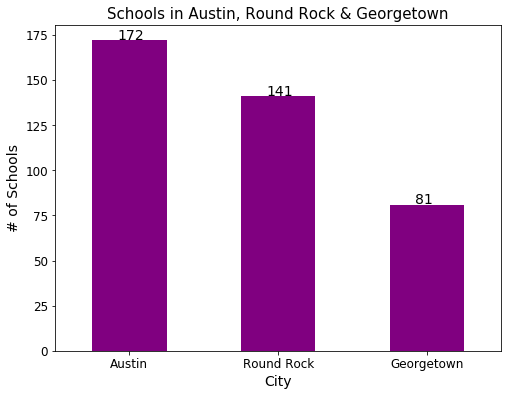

In [17]:
# Schools 

ax = schools_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12, color='purple')
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("# of Schools", fontsize=14)
plt.title("Schools in Austin, Round Rock & Georgetown", fontsize=15)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+0.6, str(i.get_height()), fontsize=14)



#### Leveraging categories in foursquare to provide schools available.

#### Grouping the categories

In [29]:
summary = schools_dataframe.groupby('CityName').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Latitude', 'Longitude', 'Venue', 'category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,CityName,cattype,Count
0,Georgetown,81,81
1,Round Rock,141,141
2,Austin,172,172


#### 2. Food

In [18]:
# Food
food_list = [
    "4d4b7105d754a06374d81259", "4bf58dd8d48988d14e941735", "4bf58dd8d48988d142941735", "4bf58dd8d48988d111941735", 
"4bf58dd8d48988d113941735", "4eb1d5724b900d56c88a45fe", "4bf58dd8d48988d1d1941735", "4bf58dd8d48988d149941735", 
"4bf58dd8d48988d1df931735", "4bf58dd8d48988d143941735", "4bf58dd8d48988d16d941735", "4bf58dd8d48988d1e0931735", 
 "4bf58dd8d48988d147941735", "4bf58dd8d48988d16e941735"]

# creating an empty dataframe to store the results
food_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
category_list =[]
category_type=[]
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in food_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            category_list.append(response['response']['venues'][i]['name'])
            category_type.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
food_dataframe["CityName"] = city_list
food_dataframe["Venue"] = venues_list
food_dataframe["category"]= category_list
food_dataframe["Latitude"] = latitude_list
food_dataframe["cattype"]= category_type
food_dataframe["Longitude"] = longitude_list


In [ ]:
# Food
food_list = [
    "4d4b7105d754a06374d81259", "4bf58dd8d48988d14e941735", "4bf58dd8d48988d142941735", "4bf58dd8d48988d111941735", 
"4bf58dd8d48988d113941735", "4eb1d5724b900d56c88a45fe", "4bf58dd8d48988d1d1941735", "4bf58dd8d48988d149941735", 
"4bf58dd8d48988d1df931735", "4bf58dd8d48988d143941735", "4bf58dd8d48988d16d941735", "4bf58dd8d48988d1e0931735", 
 "4bf58dd8d48988d147941735", "4bf58dd8d48988d16e941735"]

# creating an empty dataframe to store the results
food_dataframe = pd.DataFrame(columns=["CityName", "Venue", "Latitude", "Longitude"])
venues_list = []
category_list =[]
category_type=[]
latitude_list = []
longitude_list = []
city_list = []

for city in range(3):
    for category in food_list:
        response = requests.get(requestPayload(top_city_df.loc[city, "Latitude"], top_city_df.loc[city, "Longitude"], category)).json()
        for i in range(len(response['response']['venues'])):
            venues_list.append(response['response']['venues'][i]['name'])
            category_list.append(response['response']['venues'][i]['name'])
            category_type.append(response['response']['venues'][i]['name'])
            latitude_list.append(response['response']['venues'][i]['location']['lat'])
            longitude_list.append(response['response']['venues'][i]['location']['lng'])
            city_list.append(top_city_df.loc[city, "CityName"])
            
food_dataframe["CityName"] = city_list
food_dataframe["Venue"] = venues_list
food_dataframe["category"]= category_list
food_dataframe["Latitude"] = latitude_list
food_dataframe["cattype"]= category_type
food_dataframe["Longitude"] = longitude_list


In [ ]:
food_dataframe.to_csv(r'c:\users\msanford\food.csv')

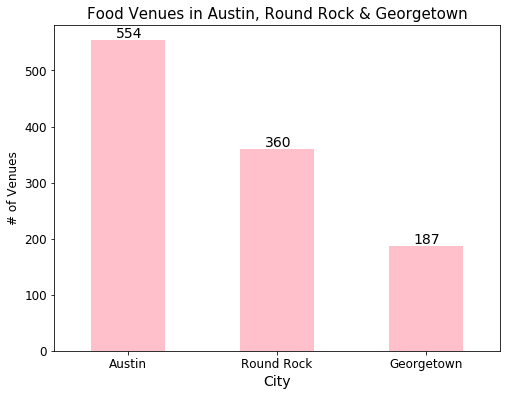

In [19]:
# Food venues 
ax = food_dataframe['CityName'].value_counts().plot(kind='bar', figsize=(8,6), fontsize=12, color='pink')
ax.set_xlabel("City", fontsize=14)
plt.xticks(rotation=0)
ax.set_ylabel("# of Venues", fontsize=12)
plt.title("Food Venues in Austin, Round Rock & Georgetown", fontsize=15)

for i in ax.patches:
    ax.text(i.get_x()+.17, i.get_height()+4.0, str(i.get_height()), fontsize=14)

### Leveraging categories in foursquare to provide food vendues available.

### Grouping for count

In [32]:
summary = food_dataframe.groupby('CityName').count().reset_index()
summary['Count'] = summary['Venue']
summary = summary.drop(['Latitude', 'Longitude', 'Venue', 'category'], axis=1)
summary = summary.sort_values('Count').reset_index(drop=True)
summary.head()

,CityName,cattype,Count
0,Georgetown,187,187
1,Round Rock,360,360
2,Austin,554,554


<H2> Map of the food and school venues in Austin

In [20]:
# Combining all different venue categories of Austin into a single dataframe
austin_dataframe = pd.concat([
    
    food_dataframe[food_dataframe.CityName == "Austin"],
    schools_dataframe[schools_dataframe.CityName == "Austin"]],ignore_index=True)

print(austin_dataframe.shape)

(726, 6)


In [26]:
# Map of all these Austin venues into a map
austin_map = folium.Map(location=[30.271129, -97.743700], zoom_start=11)

# adding markers
for lat, lng, venue in zip(austin_dataframe['Latitude'], austin_dataframe['Longitude'], austin_dataframe['Venue']):
    label = "".format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.3,
        parse_html=False).add_to(austin_map)

# Austin with all category venues plotted
austin_map

In [ ]:
<H2>Results and Conclusion

* Austin and the surrounding areas of Round Rock, Georgetown were the most populated.
* Austin has a very good pricing range and is a good choice for a home buyer. 
* This result was proven with the number of schools, food venues, home values and forecasting analysis and data.  
* The projected forecast for the median home in Austin was clearly proved to be on the rise in the next year.  
* The clustering and grouping of the data sets and methodologies noted led to some insight that is supported by the data itself.   

<H2>It’s a great spot to call home and work remotely!  
